In [ ]:
import json
import pandas as pd
from tqdm import tqdm

# Load and explore the dataset structure first
print("Loading and exploring dataset structure...")
with open("/content/qrecc-training.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# First, let's understand the data structure
print(f"Dataset type: {type(data)}")
print(f"Number of items: {len(data)}")

# Examine a few samples to understand the structure
print("\nSample items from dataset:")
for i in range(min(3, len(data))):
    print(f"Item {i}: {json.dumps(data[i], indent=2)[:500]}...")

# More robust extraction function
def extract_query_doc_pairs(data):
    pairs = []

    for item in tqdm(data, desc="Extracting pairs"):
        # Handle different possible structures
        if isinstance(item, dict):
            query = None
            doc = None

            # Extract query
            if "Rewrite" in item and isinstance(item["Rewrite"], str) and item["Rewrite"].strip():
                query = item["Rewrite"]
            elif "Question" in item and isinstance(item["Question"], str) and item["Question"].strip():
                query = item["Question"]
            elif "query" in item and isinstance(item["query"], str) and item["query"].strip():
                query = item["query"]

            # Extract document/passage - Prioritize Answer, then relevant_passages, then Context
            if "Answer" in item and isinstance(item["Answer"], str) and item["Answer"].strip():
                doc = item["Answer"]
            elif "relevant_passages" in item:
                if isinstance(item["relevant_passages"], str) and item["relevant_passages"].strip():
                    doc = item["relevant_passages"]
                elif isinstance(item["relevant_passages"], list) and item["relevant_passages"]:
                    # Join passages if they are strings, or take the first one
                    str_passages = [p for p in item["relevant_passages"] if isinstance(p, str) and p.strip()]
                    if str_passages:
                        doc = " ".join(str_passages)
            elif "Context" in item and isinstance(item["Context"], list) and item["Context"]:
                # Join context turns if they are strings
                str_context = [c for c in item["Context"] if isinstance(c, str) and c.strip()]
                if str_context:
                    doc = " ".join(str_context)

            # Clean and validate
            if query and doc:
                query = query.strip()
                doc = doc.strip()
                if query and doc and len(query) > 5 and len(doc) > 10:  # Basic validation
                    pairs.append({"query": query, "doc": doc})

    return pairs

# Extract pairs
print("\nExtracting query-document pairs...")
pairs = extract_query_doc_pairs(data)
print(f"Extracted {len(pairs)} valid (query, doc) pairs.")

# Save the extracted pairs for reference
with open("/content/extracted_pairs.json", "w", encoding="utf-8") as f:
    json.dump(pairs, f, indent=2, ensure_ascii=False)

print("Data extraction completed successfully!")

Loading and exploring dataset structure...
Dataset type: <class 'list'>
Number of items: 63501

Sample items from dataset:
Item 0: {
  "Context": [],
  "Question": "What can you tell me about Gary Cherone?",
  "Rewrite": "What can you tell me about Gary Cherone?",
  "Answer": "Gary Francis Caine Cherone is an American rock singer and songwriter, known for his work as the lead vocalist of Extreme and for his short stint for Van Halen.",
  "Answer_URL": "https://en.wikipedia.org/wiki/Van_Halen",
  "Conversation_no": 1,
  "Turn_no": 1,
  "Conversation_source": "quac"
}...
Item 1: {
  "Context": [
    "What can you tell me about Gary Cherone?",
    "Gary Francis Caine Cherone is an American rock singer and songwriter, known for his work as the lead vocalist of Extreme and for his short stint for Van Halen."
  ],
  "Question": "Did Gary sing well?",
  "Rewrite": "Did Gary Cherone sing well?",
  "Answer": "Yes, Gary Cherone is also known for his work as the lead vocalist of the Boston rock g

Extracting pairs: 100%|██████████| 63501/63501 [00:00<00:00, 125100.57it/s]


Extracted 61344 valid (query, doc) pairs.
Data extraction completed successfully!


In [ ]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import os

# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Use a better teacher model for retrieval
teacher_model_name = "sentence-transformers/multi-qa-mpnet-base-dot-v1"  # Better for QA/retrieval
output_path = "/content/teacher_soft_labels.json"

print(f"Loading teacher model: {teacher_model_name}")
teacher_tokenizer = AutoTokenizer.from_pretrained(teacher_model_name)
teacher_model = AutoModel.from_pretrained(teacher_model_name).to(device)
teacher_model.eval()

# Better pooling strategy
def smart_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

def get_embeddings(texts, tokenizer, model, batch_size=32, max_length=512):
    """Get embeddings for a list of texts efficiently"""
    embeddings = []

    for i in tqdm(range(0, len(texts), batch_size), desc="Computing embeddings"):
        batch_texts = texts[i:i + batch_size]

        inputs = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            batch_embeddings = smart_pooling(outputs, inputs['attention_mask'])
            batch_embeddings = F.normalize(batch_embeddings, p=2, dim=1)
            embeddings.append(batch_embeddings.cpu())

    return torch.cat(embeddings)

print("\nComputing teacher embeddings...")
# Separate queries and docs
queries = [pair["query"] for pair in pairs]
docs = [pair["doc"] for pair in pairs]

# Get embeddings in batches
query_embeddings = get_embeddings(queries, teacher_tokenizer, teacher_model)
doc_embeddings = get_embeddings(docs, teacher_tokenizer, teacher_model)

print("Computing similarities...")
# Compute cosine similarities
teacher_scores = F.cosine_similarity(query_embeddings, doc_embeddings).numpy()

# Create results
results = []
for i, (pair, score) in enumerate(zip(pairs, teacher_scores)):
    results.append({
        "query": pair["query"],
        "doc": pair["doc"],
        "teacher_score": float(score),
        "pair_id": i
    })

# Save results
print(f"Saving {len(results)} teacher scores to {output_path}")
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(results, f, indent=2, ensure_ascii=False)

# Analyze score distribution
scores = [r["teacher_score"] for r in results]
print(f"\nTeacher Score Statistics:")
print(f"Mean: {np.mean(scores):.4f}")
print(f"Std: {np.std(scores):.4f}")
print(f"Min: {np.min(scores):.4f}")
print(f"Max: {np.max(scores):.4f}")
print(f"Median: {np.median(scores):.4f}")

# Show some high-quality pairs
print("\nTop 5 high-similarity pairs:")
high_similarity = sorted(results, key=lambda x: x["teacher_score"], reverse=True)[:5]
for i, item in enumerate(high_similarity):
    print(f"{i+1}. Score: {item['teacher_score']:.4f}")
    print(f"   Query: {item['query'][:100]}...")
    print(f"   Doc: {item['doc'][:100]}...\n")

Using device: cuda
Loading teacher model: sentence-transformers/multi-qa-mpnet-base-dot-v1

Computing teacher embeddings...


Computing embeddings: 100%|██████████| 1917/1917 [08:40<00:00,  3.68it/s]


Computing similarities...
Saving 61344 teacher scores to /content/teacher_soft_labels.json

Teacher Score Statistics:
Mean: 0.6666
Std: 0.1218
Min: 0.1154
Max: 1.0000
Median: 0.6749

Top 5 high-similarity pairs:
1. Score: 1.0000
   Query: The Famous Flames were inducted in April 2012 alongside other backing groups like The Midnighters (H...
   Doc: The Famous Flames were inducted in April 2012 alongside other backing groups like The Midnighters (H...

2. Score: 1.0000
   Query: what was Charles Baudelaire stance on democracy?...
   Doc: what was Charles Baudelaire stance on democracy?...

3. Score: 1.0000
   Query: Where did Lionel Conacher play?...
   Doc: Where did Lionel Conacher play?...

4. Score: 0.9937
   Query: n the late 1950s and early 1960s Barber was mainly responsible for arranging the first UK tours of b...
   Doc: In the late 1950s and early 1960s Barber was mainly responsible for arranging the first UK tours of ...

5. Score: 0.9793
   Query: how many women's correction

Loading teacher scores...
Threshold candidates:
mean + 0.5std: 0.7275 -> 20000 pairs (32.6%)
mean + 1std: 0.7884 -> 9756 pairs (15.9%)
75th_percentile: 0.7526 -> 15336 pairs (25.0%)
80th_percentile: 0.7714 -> 12269 pairs (20.0%)
85th_percentile: 0.7923 -> 9202 pairs (15.0%)


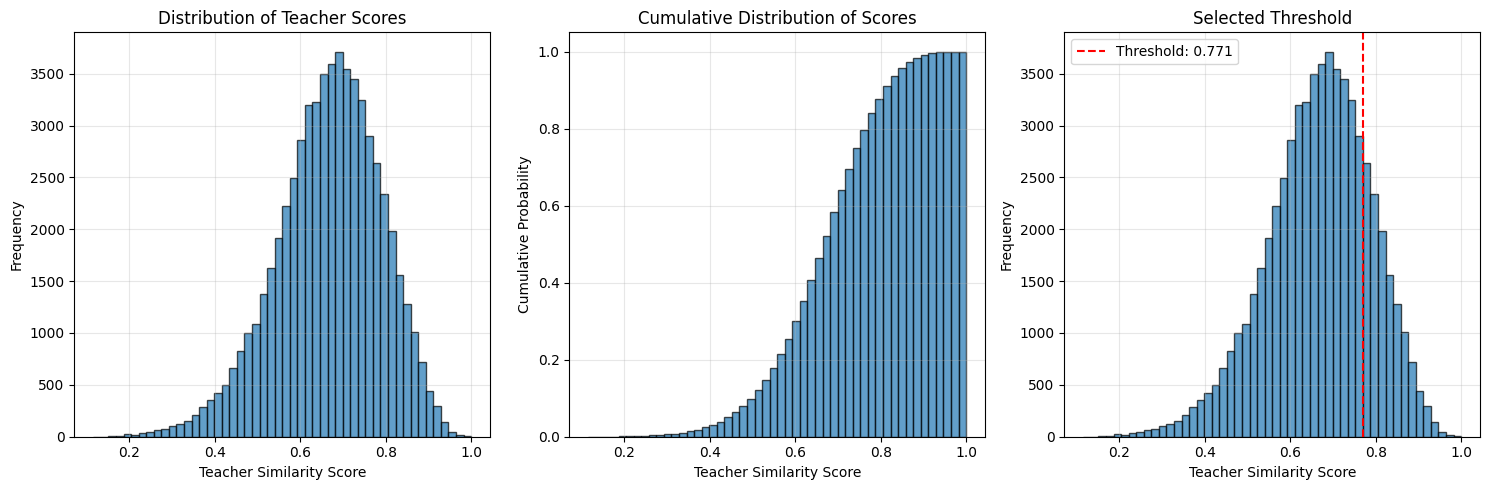


Filtering with threshold: 0.7714
Filtered from 61344 to 12269 pairs (20.0%)
Filtered dataset saved to: /content/selected_qrecc_sd.json

Sample pairs from filtered dataset:
High similarity (>0.8):
Score: 0.8037
Query: Why did Sean Combs change his name?
Doc: Sean Combs says name change is an evolution of my soul and my vibration“...

Score: 0.8223
Query: Did Sean Combs continue to be called Love?
Doc: Sean Combs continued to call himself Love, but it is unclear if his fans followed in his footsteps....

Medium similarity (0.7-0.8):
Score: 0.7839
Query: How did David M. Shoup do in school?
Doc: David M. Shoup was an excellent student, maintaining high marks in French, English, physics, and history....

Score: 0.7725
Query: Was David M. Shoup in any other activities?
Doc: Additionally, David M. Shoup was involved in several extracurricular activities such as being class president in his senior year....



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve

# Load teacher scores
print("Loading teacher scores...")
with open("/content/teacher_soft_labels.json", "r", encoding="utf-8") as f:
    teacher_data = json.load(f)

# Analyze score distribution
scores = [item["teacher_score"] for item in teacher_data]

plt.figure(figsize=(15, 5))

# Plot 1: Distribution of scores
plt.subplot(1, 3, 1)
plt.hist(scores, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Teacher Similarity Score')
plt.ylabel('Frequency')
plt.title('Distribution of Teacher Scores')
plt.grid(True, alpha=0.3)

# Plot 2: Cumulative distribution
plt.subplot(1, 3, 2)
plt.hist(scores, bins=50, cumulative=True, density=True, alpha=0.7, edgecolor='black')
plt.xlabel('Teacher Similarity Score')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution of Scores')
plt.grid(True, alpha=0.3)

# Dynamic threshold selection based on distribution
mean_score = np.mean(scores)
std_score = np.std(scores)

# Try multiple threshold strategies
threshold_candidates = {
    "mean + 0.5std": mean_score + 0.5 * std_score,
    "mean + 1std": mean_score + 1 * std_score,
    "75th_percentile": np.percentile(scores, 75),
    "80th_percentile": np.percentile(scores, 80),
    "85th_percentile": np.percentile(scores, 85)
}

print("Threshold candidates:")
for name, threshold in threshold_candidates.items():
    count = sum(1 for s in scores if s >= threshold)
    print(f"{name}: {threshold:.4f} -> {count} pairs ({count/len(scores)*100:.1f}%)")

# Use 80th percentile as default (balanced)
selected_threshold = threshold_candidates["80th_percentile"]

# Plot 3: Threshold visualization
plt.subplot(1, 3, 3)
plt.hist(scores, bins=50, alpha=0.7, edgecolor='black')
plt.axvline(selected_threshold, color='red', linestyle='--', label=f'Threshold: {selected_threshold:.3f}')
plt.xlabel('Teacher Similarity Score')
plt.ylabel('Frequency')
plt.title('Selected Threshold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Filter data
print(f"\nFiltering with threshold: {selected_threshold:.4f}")
filtered_data = [item for item in teacher_data if item["teacher_score"] >= selected_threshold]
print(f"Filtered from {len(teacher_data)} to {len(filtered_data)} pairs ({len(filtered_data)/len(teacher_data)*100:.1f}%)")

# Save filtered data
output_path = "/content/selected_qrecc_sd.json"
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(filtered_data, f, indent=2, ensure_ascii=False)

print(f"Filtered dataset saved to: {output_path}")

# Show samples from different score ranges
print("\nSample pairs from filtered dataset:")
print("High similarity (>0.8):")
high_samples = [item for item in filtered_data if item["teacher_score"] > 0.8][:2]
for sample in high_samples:
    print(f"Score: {sample['teacher_score']:.4f}")
    print(f"Query: {sample['query']}")
    print(f"Doc: {sample['doc'][:150]}...\n")

print("Medium similarity (0.7-0.8):")
med_samples = [item for item in filtered_data if 0.7 <= item["teacher_score"] <= 0.8][:2]
for sample in med_samples:
    print(f"Score: {sample['teacher_score']:.4f}")
    print(f"Query: {sample['query']}")
    print(f"Doc: {sample['doc'][:150]}...\n")

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from torch.optim import AdamW # Corrected import
import numpy as np
from tqdm import tqdm
import os

# Configuration
class Config:
    student_model_name = "microsoft/MiniLM-L12-H384-uncased"  # Better small model
    batch_size = 16
    learning_rate = 5e-5
    weight_decay = 0.01
    epochs = 8
    max_length = 256
    warmup_ratio = 0.1
    temperature = 0.1  # Lower temperature for sharper distillation

config = Config()

# Load filtered data
print("Loading filtered data...")
with open("/content/selected_qrecc_sd.json", "r", encoding="utf-8") as f:
    filtered_data = json.load(f)

print(f"Loaded {len(filtered_data)} pairs for distillation")

# Improved Dataset class
class DistillationDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=256):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        # Tokenize query and document
        query_enc = self.tokenizer(
            item["query"],
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )

        doc_enc = self.tokenizer(
            item["doc"],
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "query_input_ids": query_enc["input_ids"].squeeze(0),
            "query_attention_mask": query_enc["attention_mask"].squeeze(0),
            "doc_input_ids": doc_enc["input_ids"].squeeze(0),
            "doc_attention_mask": doc_enc["attention_mask"].squeeze(0),
            "teacher_score": torch.tensor(item["teacher_score"], dtype=torch.float)
        }

# Enhanced Student Model with projection head
class EnhancedStudentModel(nn.Module):
    def __init__(self, model_name, projection_dim=256):
        super().__init__()
        self.transformer = AutoModel.from_pretrained(model_name)
        self.projection = nn.Linear(self.transformer.config.hidden_size, projection_dim)
        self.dropout = nn.Dropout(0.1)

    def forward(self, input_ids, attention_mask):
        outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        # Use [CLS] token representation
        cls_embedding = outputs.last_hidden_state[:, 0, :]
        projected = self.projection(cls_embedding)
        projected = self.dropout(projected)
        return F.normalize(projected, p=2, dim=1)

# Initialize model and tokenizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

tokenizer = AutoTokenizer.from_pretrained(config.student_model_name)
student_model = EnhancedStudentModel(config.student_model_name).to(device)

# Create dataset and dataloader
dataset = DistillationDataset(filtered_data, tokenizer, config.max_length)
dataloader = DataLoader(dataset, batch_size=config.batch_size, shuffle=True, num_workers=2)

# Optimizer and scheduler
optimizer = AdamW(
    student_model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

total_steps = len(dataloader) * config.epochs
warmup_steps = int(total_steps * config.warmup_ratio)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

# Loss function - Combined contrastive and regression loss
def distillation_loss(student_scores, teacher_scores, temperature=config.temperature):
    # Contrastive loss
    batch_size = student_scores.size(0)
    labels = torch.arange(batch_size).to(device)

    # Scale logits by temperature
    logits = student_scores / temperature

    # Cross entropy loss for contrastive learning
    contrastive_loss = F.cross_entropy(logits, labels)

    # Regression loss to match teacher scores (optional)
    # This helps the student learn the absolute similarity values
    diag_scores = torch.diag(student_scores)
    regression_loss = F.mse_loss(diag_scores, teacher_scores)

    # Combined loss
    total_loss = contrastive_loss + 0.1 * regression_loss
    return total_loss, contrastive_loss, regression_loss

# Training loop
print("Starting distillation training...")
student_model.train()
best_loss = float('inf')
patience = 3
patience_counter = 0

for epoch in range(config.epochs):
    total_loss = 0
    total_contrastive = 0
    total_regression = 0

    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{config.epochs}")

    for batch in progress_bar:
        # Move batch to device
        query_input_ids = batch["query_input_ids"].to(device)
        query_attention_mask = batch["query_attention_mask"].to(device)
        doc_input_ids = batch["doc_input_ids"].to(device)
        doc_attention_mask = batch["doc_attention_mask"].to(device)
        teacher_scores = batch["teacher_score"].to(device)

        # Get student embeddings
        query_emb = student_model(query_input_ids, query_attention_mask)
        doc_emb = student_model(doc_input_ids, doc_attention_mask)

        # Compute similarity matrix
        student_similarity = torch.matmul(query_emb, doc_emb.T)

        # Compute loss
        loss, contrastive_loss, regression_loss = distillation_loss(
            student_similarity, teacher_scores
        )

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student_model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        # Update metrics
        total_loss += loss.item()
        total_contrastive += contrastive_loss.item()
        total_regression += regression_loss.item()

        # Update progress bar
        progress_bar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Contrastive': f'{contrastive_loss.item():.4f}',
            'Regression': f'{regression_loss.item():.4f}'
        })

    # Epoch statistics
    avg_loss = total_loss / len(dataloader)
    avg_contrastive = total_contrastive / len(dataloader)
    avg_regression = total_regression / len(dataloader)

    print(f"Epoch {epoch+1}/{config.epochs}:")
    print(f"  Avg Loss: {avg_loss:.4f}")
    print(f"  Avg Contrastive: {avg_contrastive:.4f}")
    print(f"  Avg Regression: {avg_regression:.4f}")

    # Early stopping check
    if avg_loss < best_loss:
        best_loss = avg_loss
        patience_counter = 0
        # Save best model
        torch.save(student_model.state_dict(), "/content/best_student_model.pt")
        print("  Saved best model!")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping after {epoch+1} epochs")
            break

# Load best model for final save
student_model.load_state_dict(torch.load("/content/best_student_model.pt"))

# Save final model
save_path = "/content/student_model_sd"
os.makedirs(save_path, exist_ok=True)

# Save model and tokenizer
student_model.transformer.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

# Save projection weights separately
torch.save({
    'projection_state_dict': student_model.projection.state_dict(),
    'config': config.__dict__
}, f"{save_path}/projection.pt")

print(f"Student model saved to: {save_path}")

Loading filtered data...
Loaded 12269 pairs for distillation
Using device: cuda


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/133M [00:00<?, ?B/s]

Starting distillation training...


Epoch 1/8:   0%|          | 2/767 [00:01<10:13,  1.25it/s, Loss=2.7868, Contrastive=2.7863, Regression=0.0056]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

Epoch 1/8: 100%|██████████| 767/767 [05:30<00:00,  2.32it/s, Loss=0.1352, Contrastive=0.1337, Regression=0.0150]


Epoch 1/8:
  Avg Loss: 0.9686
  Avg Contrastive: 0.9658
  Avg Regression: 0.0281
  Saved best model!


Epoch 2/8: 100%|██████████| 767/767 [05:29<00:00,  2.33it/s, Loss=0.2658, Contrastive=0.2616, Regression=0.0420]


Epoch 2/8:
  Avg Loss: 0.0886
  Avg Contrastive: 0.0871
  Avg Regression: 0.0148
  Saved best model!


Epoch 3/8: 100%|██████████| 767/767 [05:29<00:00,  2.32it/s, Loss=0.0167, Contrastive=0.0163, Regression=0.0038]


Epoch 3/8:
  Avg Loss: 0.0463
  Avg Contrastive: 0.0455
  Avg Regression: 0.0078
  Saved best model!


Epoch 4/8: 100%|██████████| 767/767 [05:29<00:00,  2.33it/s, Loss=0.0323, Contrastive=0.0319, Regression=0.0043]


Epoch 4/8:
  Avg Loss: 0.0338
  Avg Contrastive: 0.0333
  Avg Regression: 0.0055
  Saved best model!


Epoch 5/8: 100%|██████████| 767/767 [05:30<00:00,  2.32it/s, Loss=0.0160, Contrastive=0.0153, Regression=0.0066]


Epoch 5/8:
  Avg Loss: 0.0271
  Avg Contrastive: 0.0267
  Avg Regression: 0.0043
  Saved best model!


Epoch 6/8: 100%|██████████| 767/767 [05:30<00:00,  2.32it/s, Loss=0.0269, Contrastive=0.0267, Regression=0.0026]


Epoch 6/8:
  Avg Loss: 0.0230
  Avg Contrastive: 0.0226
  Avg Regression: 0.0038
  Saved best model!


Epoch 7/8: 100%|██████████| 767/767 [05:30<00:00,  2.32it/s, Loss=0.0132, Contrastive=0.0126, Regression=0.0063]


Epoch 7/8:
  Avg Loss: 0.0210
  Avg Contrastive: 0.0207
  Avg Regression: 0.0033
  Saved best model!


Epoch 8/8: 100%|██████████| 767/767 [05:30<00:00,  2.32it/s, Loss=0.0087, Contrastive=0.0081, Regression=0.0058]


Epoch 8/8:
  Avg Loss: 0.0194
  Avg Contrastive: 0.0191
  Avg Regression: 0.0032
  Saved best model!
Student model saved to: /content/student_model_sd


Loading models for evaluation...
Evaluating on 12269 pairs...
Computing embeddings...
Computing similarities...

EVALUATION RESULTS
Pearson Correlation: 0.3531
Mean Absolute Error: 0.1454

Binary Classification (threshold=0.817):
Accuracy:  0.5013
Precision: 0.5007
Recall:    0.9998
F1 Score:  0.6672

Ranking Metrics:
Recall@1: 1.0000
Recall@5: 0.8000
Recall@10: 0.4000
Recall@20: 0.3000


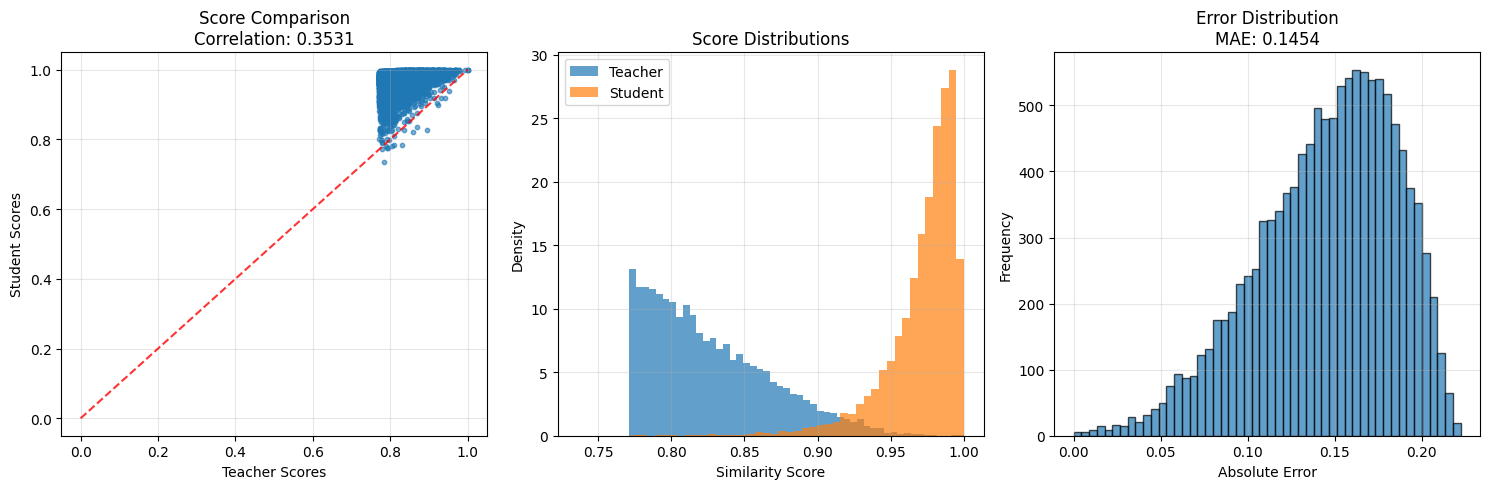


Detailed Analysis by Score Ranges:
Range [0.7, 0.9): 11493 samples, MAE: 0.1507, Corr: 0.3146
Range [0.9, 1.0): 773 samples, MAE: 0.0677, Corr: 0.1278

Evaluation completed!


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import average_precision_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load models for evaluation
print("Loading models for evaluation...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Teacher model
teacher_model_name = "sentence-transformers/multi-qa-mpnet-base-dot-v1"
teacher_tokenizer = AutoTokenizer.from_pretrained(teacher_model_name)
teacher_model = AutoModel.from_pretrained(teacher_model_name).to(device)
teacher_model.eval()

# Student model
student_path = "/content/student_model_sd"
student_tokenizer = AutoTokenizer.from_pretrained(student_path)
student_model = EnhancedStudentModel(student_path).to(device)
student_model.load_state_dict(torch.load("/content/best_student_model.pt"), strict=False)
student_model.eval()

# Load evaluation data
with open("/content/selected_qrecc_sd.json", "r", encoding="utf-8") as f:
    eval_data = json.load(f)

print(f"Evaluating on {len(eval_data)} pairs...")

def get_embeddings_batch(model, tokenizer, texts, batch_size=32):
    """Get embeddings for a batch of texts"""
    embeddings = []

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]

        inputs = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=256,
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            if model == teacher_model:
                outputs = model(**inputs)
                # Use mean pooling for teacher
                attention_mask = inputs['attention_mask']
                token_embeddings = outputs.last_hidden_state
                input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
                batch_emb = torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)
            else:
                # Student model uses CLS token with projection
                batch_emb = model(inputs['input_ids'], inputs['attention_mask'])

            batch_emb = F.normalize(batch_emb, p=2, dim=1)
            embeddings.append(batch_emb.cpu())

    return torch.cat(embeddings)

# Get embeddings
print("Computing embeddings...")
queries = [item["query"] for item in eval_data]
docs = [item["doc"] for item in eval_data]

teacher_query_emb = get_embeddings_batch(teacher_model, teacher_tokenizer, queries)
teacher_doc_emb = get_embeddings_batch(teacher_model, teacher_tokenizer, docs)

student_query_emb = get_embeddings_batch(student_model, student_tokenizer, queries)
student_doc_emb = get_embeddings_batch(student_model, student_tokenizer, docs)

# Compute similarities
print("Computing similarities...")
teacher_sims = F.cosine_similarity(teacher_query_emb, teacher_doc_emb).numpy()
student_sims = F.cosine_similarity(student_query_emb, student_doc_emb).numpy()

# Get ground truth teacher scores
teacher_scores = np.array([item["teacher_score"] for item in eval_data])

# Analysis
print("\n" + "="*50)
print("EVALUATION RESULTS")
print("="*50)

# 1. Correlation analysis
correlation = np.corrcoef(teacher_scores, student_sims)[0, 1]
print(f"Pearson Correlation: {correlation:.4f}")

# 2. Mean Absolute Error
mae = np.mean(np.abs(teacher_scores - student_sims))
print(f"Mean Absolute Error: {mae:.4f}")

# 3. Ranking evaluation (Recall@K)
def recall_at_k(teacher_scores, student_scores, k=10):
    """Compute recall@k - how many of teacher's top K are in student's top K"""
    teacher_topk = np.argsort(teacher_scores)[-k:][::-1]
    student_topk = np.argsort(student_scores)[-k:][::-1]
    return len(set(teacher_topk) & set(student_topk)) / k

# 4. Precision-Recall analysis
def compute_binary_metrics(teacher_scores, student_scores, threshold):
    teacher_binary = (teacher_scores >= threshold).astype(int)
    student_binary = (student_scores >= threshold).astype(int)

    accuracy = accuracy_score(teacher_binary, student_binary)
    precision = precision_score(teacher_binary, student_binary, zero_division=0)
    recall = recall_score(teacher_binary, student_binary, zero_division=0)
    f1 = f1_score(teacher_binary, student_binary, zero_division=0)

    return accuracy, precision, recall, f1

# Use median threshold for binary classification
threshold = np.median(teacher_scores)
accuracy, precision, recall, f1 = compute_binary_metrics(teacher_scores, student_sims, threshold)

print(f"\nBinary Classification (threshold={threshold:.3f}):")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Ranking metrics
print(f"\nRanking Metrics:")
for k in [1, 5, 10, 20]:
    recall_k = recall_at_k(teacher_scores, student_sims, k)
    print(f"Recall@{k}: {recall_k:.4f}")

# Visualization
plt.figure(figsize=(15, 5))

# Plot 1: Score comparison
plt.subplot(1, 3, 1)
plt.scatter(teacher_scores, student_sims, alpha=0.6, s=10)
plt.plot([0, 1], [0, 1], 'r--', alpha=0.8)
plt.xlabel('Teacher Scores')
plt.ylabel('Student Scores')
plt.title(f'Score Comparison\nCorrelation: {correlation:.4f}')
plt.grid(True, alpha=0.3)

# Plot 2: Distribution comparison
plt.subplot(1, 3, 2)
plt.hist(teacher_scores, bins=50, alpha=0.7, label='Teacher', density=True)
plt.hist(student_sims, bins=50, alpha=0.7, label='Student', density=True)
plt.xlabel('Similarity Score')
plt.ylabel('Density')
plt.title('Score Distributions')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Error distribution
plt.subplot(1, 3, 3)
errors = np.abs(teacher_scores - student_sims)
plt.hist(errors, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')
plt.title(f'Error Distribution\nMAE: {mae:.4f}')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Detailed analysis by score ranges
print("\nDetailed Analysis by Score Ranges:")
score_ranges = [(0.0, 0.5), (0.5, 0.7), (0.7, 0.9), (0.9, 1.0)]

for low, high in score_ranges:
    mask = (teacher_scores >= low) & (teacher_scores < high)
    if mask.sum() > 0:
        range_mae = np.mean(np.abs(teacher_scores[mask] - student_sims[mask]))
        range_corr = np.corrcoef(teacher_scores[mask], student_sims[mask])[0, 1] if len(teacher_scores[mask]) > 1 else 0
        print(f"Range [{low:.1f}, {high:.1f}): {mask.sum()} samples, MAE: {range_mae:.4f}, Corr: {range_corr:.4f}")

print("\nEvaluation completed!")

In [ ]:
# Final validation and model packaging
print("Performing final validation...")

# Test on a few samples
test_samples = eval_data[:5]
print("\nSample Predictions:")
print("="*100)

for i, sample in enumerate(test_samples):
    # Tokenize
    query_inputs = student_tokenizer(
        sample["query"],
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=256
    ).to(device)

    doc_inputs = student_tokenizer(
        sample["doc"],
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=256
    ).to(device)

    # Get embeddings and similarity
    with torch.no_grad():
        query_emb = student_model(query_inputs['input_ids'], query_inputs['attention_mask'])
        doc_emb = student_model(doc_inputs['input_ids'], doc_inputs['attention_mask'])
        pred_similarity = F.cosine_similarity(query_emb, doc_emb).item()

    print(f"Sample {i+1}:")
    print(f"  Query: {sample['query']}")
    print(f"  Doc: {sample['doc'][:100]}...")
    print(f"  Teacher Score: {sample['teacher_score']:.4f}")
    print(f"  Student Pred:  {pred_similarity:.4f}")
    print(f"  Error:         {abs(sample['teacher_score'] - pred_similarity):.4f}")
    print()

# Save final model with metadata
final_save_path = "/content/final_student_model"
os.makedirs(final_save_path, exist_ok=True)

# Save the complete model (transformer + projection)
torch.save({
    'model_state_dict': student_model.state_dict(),
    'tokenizer': student_tokenizer,
    'config': config.__dict__,
    'evaluation_metrics': {
        'correlation': correlation,
        'mae': mae,
        'recall@10': recall_at_k(teacher_scores, student_sims, 10)
    }
}, f"{final_save_path}/complete_model.pt")

# Also save in HuggingFace format for easy loading
student_model.transformer.save_pretrained(final_save_path)
student_tokenizer.save_pretrained(final_save_path)

# Save projection separately
torch.save(student_model.projection.state_dict(), f"{final_save_path}/projection_weights.pt")

print(f"Final model saved to: {final_save_path}")
print("\nModel Summary:")
print(f"- Base model: {config.student_model_name}")
print(f"- Projection dimension: 256")
print(f"- Training pairs: {len(filtered_data)}")
print(f"- Final correlation with teacher: {correlation:.4f}")
print(f"- Final MAE: {mae:.4f}")

# Verify model can be loaded
print("\nVerifying model loading...")
try:
    # Test loading
    test_tokenizer = AutoTokenizer.from_pretrained(final_save_path)
    test_model = EnhancedStudentModel(final_save_path).to(device)
    test_model.load_state_dict(torch.load(f"{final_save_path}/complete_model.pt")['model_state_dict'])

    # Test inference
    test_query = "What is machine learning?"
    test_doc = "Machine learning is a method of data analysis that automates analytical model building."

    query_inputs = test_tokenizer(test_query, return_tensors="pt", truncation=True, max_length=256).to(device)
    doc_inputs = test_tokenizer(test_doc, return_tensors="pt", truncation=True, max_length=256).to(device)

    with torch.no_grad():
        query_emb = test_model(query_inputs['input_ids'], query_inputs['attention_mask'])
        doc_emb = test_model(doc_inputs['input_ids'], doc_inputs['attention_mask'])
        similarity = F.cosine_similarity(query_emb, doc_emb).item()

    print(f"Test inference successful! Similarity: {similarity:.4f}")
    print("Model is ready for use!")

except Exception as e:
    print(f"Error loading model: {e}")

Performing final validation...

Sample Predictions:
Sample 1:
  Query: Why did Sean Combs change his name?
  Doc: Sean Combs says name change is an evolution of my soul and my vibration“...
  Teacher Score: 0.8037
  Student Pred:  0.9865
  Error:         0.1828

Sample 2:
  Query: Did Sean Combs continue to be called Love?
  Doc: Sean Combs continued to call himself Love, but it is unclear if his fans followed in his footsteps....
  Teacher Score: 0.8223
  Student Pred:  0.9892
  Error:         0.1670

Sample 3:
  Query: Who did Sean Combs start the company, Sean John, with?
  Doc: Sean Combs started the company by himself....
  Teacher Score: 0.8559
  Student Pred:  0.9821
  Error:         0.1262

Sample 4:
  Query: Where was David M. Shoup born?
  Doc: David Monroe Shoup was born on 30 December 1904 in Battle Ground, Indiana....
  Teacher Score: 0.8130
  Student Pred:  0.9481
  Error:         0.1351

Sample 5:
  Query: When was David M. Shoup born?
  Doc: David Monroe Shoup was born 

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

def comprehensive_evaluation(teacher_scores, student_scores, teacher_binary=None):
    """
    Comprehensive evaluation of student model against teacher
    """
    results = {}

    # 1. Regression Metrics
    mae = np.mean(np.abs(teacher_scores - student_scores))
    mse = np.mean((teacher_scores - student_scores) ** 2)
    rmse = np.sqrt(mse)
    correlation = np.corrcoef(teacher_scores, student_scores)[0, 1]

    results['regression'] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'Pearson_Correlation': correlation
    }

    # 2. Ranking Metrics
    def recall_at_k(teacher_scores, student_scores, k):
        teacher_topk = set(np.argsort(teacher_scores)[-k:][::-1])
        student_topk = set(np.argsort(student_scores)[-k:][::-1])
        return len(teacher_topk.intersection(student_topk)) / k

    def ndcg_at_k(teacher_scores, student_scores, k):
        """Normalized Discounted Cumulative Gain"""
        teacher_ranking = np.argsort(teacher_scores)[-k:][::-1]
        student_ranking = np.argsort(student_scores)[-k:][::-1]

        # Create relevance scores
        dcg = 0
        for i, idx in enumerate(student_ranking):
            if idx in teacher_ranking:
                rank_in_teacher = np.where(teacher_ranking == idx)[0][0]
                relevance = k - rank_in_teacher
                dcg += relevance / np.log2(i + 2)

        idcg = sum((k - i) / np.log2(i + 2) for i in range(min(k, k)))
        return dcg / idcg if idcg > 0 else 0

    k_values = [1, 3, 5, 10, 20, 50]
    recall_results = {}
    ndcg_results = {}

    for k in k_values:
        if k <= len(teacher_scores):
            recall_results[f'Recall@{k}'] = recall_at_k(teacher_scores, student_scores, k)
            ndcg_results[f'NDCG@{k}'] = ndcg_at_k(teacher_scores, student_scores, k)

    results['ranking'] = {
        'recall': recall_results,
        'ndcg': ndcg_results
    }

    # 3. Binary Classification Metrics (if binary labels available)
    if teacher_binary is not None:
        # Find optimal threshold using precision-recall curve
        precision, recall, thresholds = precision_recall_curve(teacher_binary, student_scores)
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
        optimal_threshold = thresholds[np.argmax(f1_scores)]

        student_binary = (student_scores >= optimal_threshold).astype(int)

        results['classification'] = {
            'Accuracy': accuracy_score(teacher_binary, student_binary),
            'Precision': precision_score(teacher_binary, student_binary, zero_division=0),
            'Recall': recall_score(teacher_binary, student_binary, zero_division=0),
            'F1_Score': f1_score(teacher_binary, student_binary, zero_division=0),
            'Average_Precision': average_precision_score(teacher_binary, student_scores),
            'ROC_AUC': roc_auc_score(teacher_binary, student_scores),
            'Optimal_Threshold': optimal_threshold
        }
    else:
        # Use median as threshold for binary conversion
        threshold = np.median(teacher_scores)
        teacher_binary = (teacher_scores >= threshold).astype(int)
        student_binary = (student_scores >= threshold).astype(int)

        results['classification'] = {
            'Accuracy': accuracy_score(teacher_binary, student_binary),
            'Precision': precision_score(teacher_binary, student_binary, zero_division=0),
            'Recall': recall_score(teacher_binary, student_binary, zero_division=0),
            'F1_Score': f1_score(teacher_binary, student_binary, zero_division=0),
            'Threshold_Used': threshold
        }

    return results

def print_results(results):
    """Print formatted results"""
    print("="*70)
    print("COMPREHENSIVE EVALUATION RESULTS")
    print("="*70)

    # Regression Metrics
    print("\n📊 REGRESSION METRICS:")
    for metric, value in results['regression'].items():
        print(f"  {metric}: {value:.4f}")

    # Ranking Metrics
    print("\n🏆 RANKING METRICS:")
    print("  Recall@K:")
    for k, recall in results['ranking']['recall'].items():
        print(f"    {k}: {recall:.4f}")

    print("  NDCG@K:")
    for k, ndcg in results['ranking']['ndcg'].items():
        print(f"    {k}: {ndcg:.4f}")

    # Classification Metrics
    print("\n🎯 CLASSIFICATION METRICS:")
    for metric, value in results['classification'].items():
        if isinstance(value, float):
            print(f"  {metric}: {value:.4f}")
        else:
            print(f"  {metric}: {value}")

def plot_evaluation_results(teacher_scores, student_scores, results):
    """Create comprehensive visualization of results"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Plot 1: Score comparison scatter plot
    axes[0, 0].scatter(teacher_scores, student_scores, alpha=0.6, s=20, color='blue')
    axes[0, 0].plot([0, 1], [0, 1], 'r--', alpha=0.8, linewidth=2)
    axes[0, 0].set_xlabel('Teacher Scores')
    axes[0, 0].set_ylabel('Student Scores')
    axes[0, 0].set_title(f'Score Comparison\nCorrelation: {results["regression"]["Pearson_Correlation"]:.4f}')
    axes[0, 0].grid(True, alpha=0.3)

    # Plot 2: Error distribution
    errors = np.abs(teacher_scores - student_scores)
    axes[0, 1].hist(errors, bins=50, alpha=0.7, color='red', edgecolor='black')
    axes[0, 1].axvline(results['regression']['MAE'], color='blue', linestyle='--',
                      label=f'MAE: {results["regression"]["MAE"]:.4f}')
    axes[0, 1].set_xlabel('Absolute Error')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Error Distribution')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Plot 3: Score distributions
    axes[0, 2].hist(teacher_scores, bins=50, alpha=0.7, label='Teacher', density=True)
    axes[0, 2].hist(student_scores, bins=50, alpha=0.7, label='Student', density=True)
    axes[0, 2].set_xlabel('Similarity Score')
    axes[0, 2].set_ylabel('Density')
    axes[0, 2].set_title('Score Distributions')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # Plot 4: Recall@K
    k_values = [int(k.split('@')[1]) for k in results['ranking']['recall'].keys()]
    recall_values = list(results['ranking']['recall'].values())
    axes[1, 0].bar(k_values, recall_values, alpha=0.7, color='green')
    axes[1, 0].set_xlabel('K')
    axes[1, 0].set_ylabel('Recall')
    axes[1, 0].set_title('Recall@K')
    axes[1, 0].grid(True, alpha=0.3)

    # Plot 5: NDCG@K
    ndcg_values = list(results['ranking']['ndcg'].values())
    axes[1, 1].bar(k_values, ndcg_values, alpha=0.7, color='orange')
    axes[1, 1].set_xlabel('K')
    axes[1, 1].set_ylabel('NDCG')
    axes[1, 1].set_title('NDCG@K')
    axes[1, 1].grid(True, alpha=0.3)

    # Plot 6: Classification metrics radar chart
    if 'ROC_AUC' in results['classification']:
        class_metrics = ['Accuracy', 'Precision', 'Recall', 'F1_Score', 'ROC_AUC']
        metric_values = [results['classification'][metric] for metric in class_metrics]
    else:
        class_metrics = ['Accuracy', 'Precision', 'Recall', 'F1_Score']
        metric_values = [results['classification'][metric] for metric in class_metrics]

    angles = np.linspace(0, 2*np.pi, len(class_metrics), endpoint=False).tolist()
    angles += angles[:1]  # Complete the circle
    metric_values += metric_values[:1]

    axes[1, 2].plot(angles, metric_values, 'o-', linewidth=2, label='Metrics')
    axes[1, 2].fill(angles, metric_values, alpha=0.25)
    axes[1, 2].set_xticks(angles[:-1])
    axes[1, 2].set_xticklabels(class_metrics)
    axes[1, 2].set_ylim(0, 1)
    axes[1, 2].set_title('Classification Metrics')
    axes[1, 2].grid(True)

    plt.tight_layout()
    plt.show()

    return fig

In [ ]:
import json
from transformers import AutoTokenizer, AutoModel
import torch

# Load your data
print("Loading data...")
with open("/content/selected_qrecc_sd.json", "r", encoding="utf-8") as f:
    eval_data = json.load(f)

print(f"Loaded {len(eval_data)} evaluation pairs")

# Initialize models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Teacher model
teacher_model_name = "sentence-transformers/multi-qa-mpnet-base-dot-v1"
teacher_tokenizer = AutoTokenizer.from_pretrained(teacher_model_name)
teacher_model = AutoModel.from_pretrained(teacher_model_name).to(device)
teacher_model.eval()

# Student model (assuming you have it saved)
class EnhancedStudentModel(torch.nn.Module):
    def __init__(self, model_name, projection_dim=256):
        super().__init__()
        self.transformer = AutoModel.from_pretrained(model_name)
        self.projection = torch.nn.Linear(self.transformer.config.hidden_size, projection_dim)

    def forward(self, input_ids, attention_mask):
        outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        cls_embedding = outputs.last_hidden_state[:, 0, :]
        projected = self.projection(cls_embedding)
        return F.normalize(projected, p=2, dim=1)

# Load student model
student_path = "/content/student_model_sd"  # Update this path
student_tokenizer = AutoTokenizer.from_pretrained(student_path)
student_model = EnhancedStudentModel(student_path).to(device)

# Load trained weights
try:
    student_model.load_state_dict(torch.load("/content/best_student_model.pt"), strict=False)
    print("✅ Student model loaded successfully!")
except:
    print("⚠️  Could not load student weights, using initialized model")

teacher_model.eval()
student_model.eval()

def compute_similarities_batch(model, tokenizer, queries, docs, batch_size=16, is_teacher=False):
    """Compute similarities between queries and docs"""
    similarities = []

    for i in range(0, len(queries), batch_size):
        batch_queries = queries[i:i+batch_size]
        batch_docs = docs[i:i+batch_size]

        # Tokenize queries
        query_inputs = tokenizer(
            batch_queries,
            padding=True,
            truncation=True,
            max_length=256,
            return_tensors="pt"
        ).to(device)

        # Tokenize docs
        doc_inputs = tokenizer(
            batch_docs,
            padding=True,
            truncation=True,
            max_length=256,
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            if is_teacher:
                # Teacher model - mean pooling
                query_outputs = teacher_model(**query_inputs)
                doc_outputs = teacher_model(**doc_inputs)

                # Mean pooling for teacher
                def mean_pool(outputs, attention_mask):
                    token_embeddings = outputs.last_hidden_state
                    mask = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
                    summed = torch.sum(token_embeddings * mask, 1)
                    counts = torch.clamp(mask.sum(1), min=1e-9)
                    return summed / counts

                query_emb = mean_pool(query_outputs, query_inputs['attention_mask'])
                doc_emb = mean_pool(doc_outputs, doc_inputs['attention_mask'])
            else:
                # Student model - uses projection
                query_emb = student_model(query_inputs['input_ids'], query_inputs['attention_mask'])
                doc_emb = student_model(doc_inputs['input_ids'], doc_inputs['attention_mask'])

            # Normalize and compute cosine similarity
            query_emb = F.normalize(query_emb, p=2, dim=1)
            doc_emb = F.normalize(doc_emb, p=2, dim=1)

            batch_similarities = F.cosine_similarity(query_emb, doc_emb)
            similarities.extend(batch_similarities.cpu().numpy())

    return np.array(similarities)

print("Computing teacher similarities...")
queries = [item["query"] for item in eval_data]
docs = [item["doc"] for item in eval_data]
teacher_scores_ground_truth = np.array([item["teacher_score"] for item in eval_data])

# Compute teacher similarities (for comparison)
teacher_similarities = compute_similarities_batch(
    teacher_model, teacher_tokenizer, queries, docs, is_teacher=True
)

print("Computing student similarities...")
student_similarities = compute_similarities_batch(
    student_model, student_tokenizer, queries, docs, is_teacher=False
)

print("Similarities computed successfully!")

Loading data...
Loaded 12269 evaluation pairs
Using device: cuda
✅ Student model loaded successfully!
Computing teacher similarities...
Computing student similarities...
Similarities computed successfully!


Running comprehensive evaluation...
COMPREHENSIVE EVALUATION RESULTS

📊 REGRESSION METRICS:
  MAE: 0.1454
  MSE: 0.0227
  RMSE: 0.1508
  Pearson_Correlation: 0.3531

🏆 RANKING METRICS:
  Recall@K:
    Recall@1: 0.0000
    Recall@3: 1.0000
    Recall@5: 0.8000
    Recall@10: 0.4000
    Recall@20: 0.3000
    Recall@50: 0.1800
  NDCG@K:
    NDCG@1: 0.0000
    NDCG@3: 0.9225
    NDCG@5: 0.9179
    NDCG@10: 0.7347
    NDCG@20: 0.5904
    NDCG@50: 0.4067

🎯 CLASSIFICATION METRICS:
  Accuracy: 0.5013
  Precision: 0.5007
  Recall: 0.9998
  F1_Score: 0.6672
  Threshold_Used: 0.8169


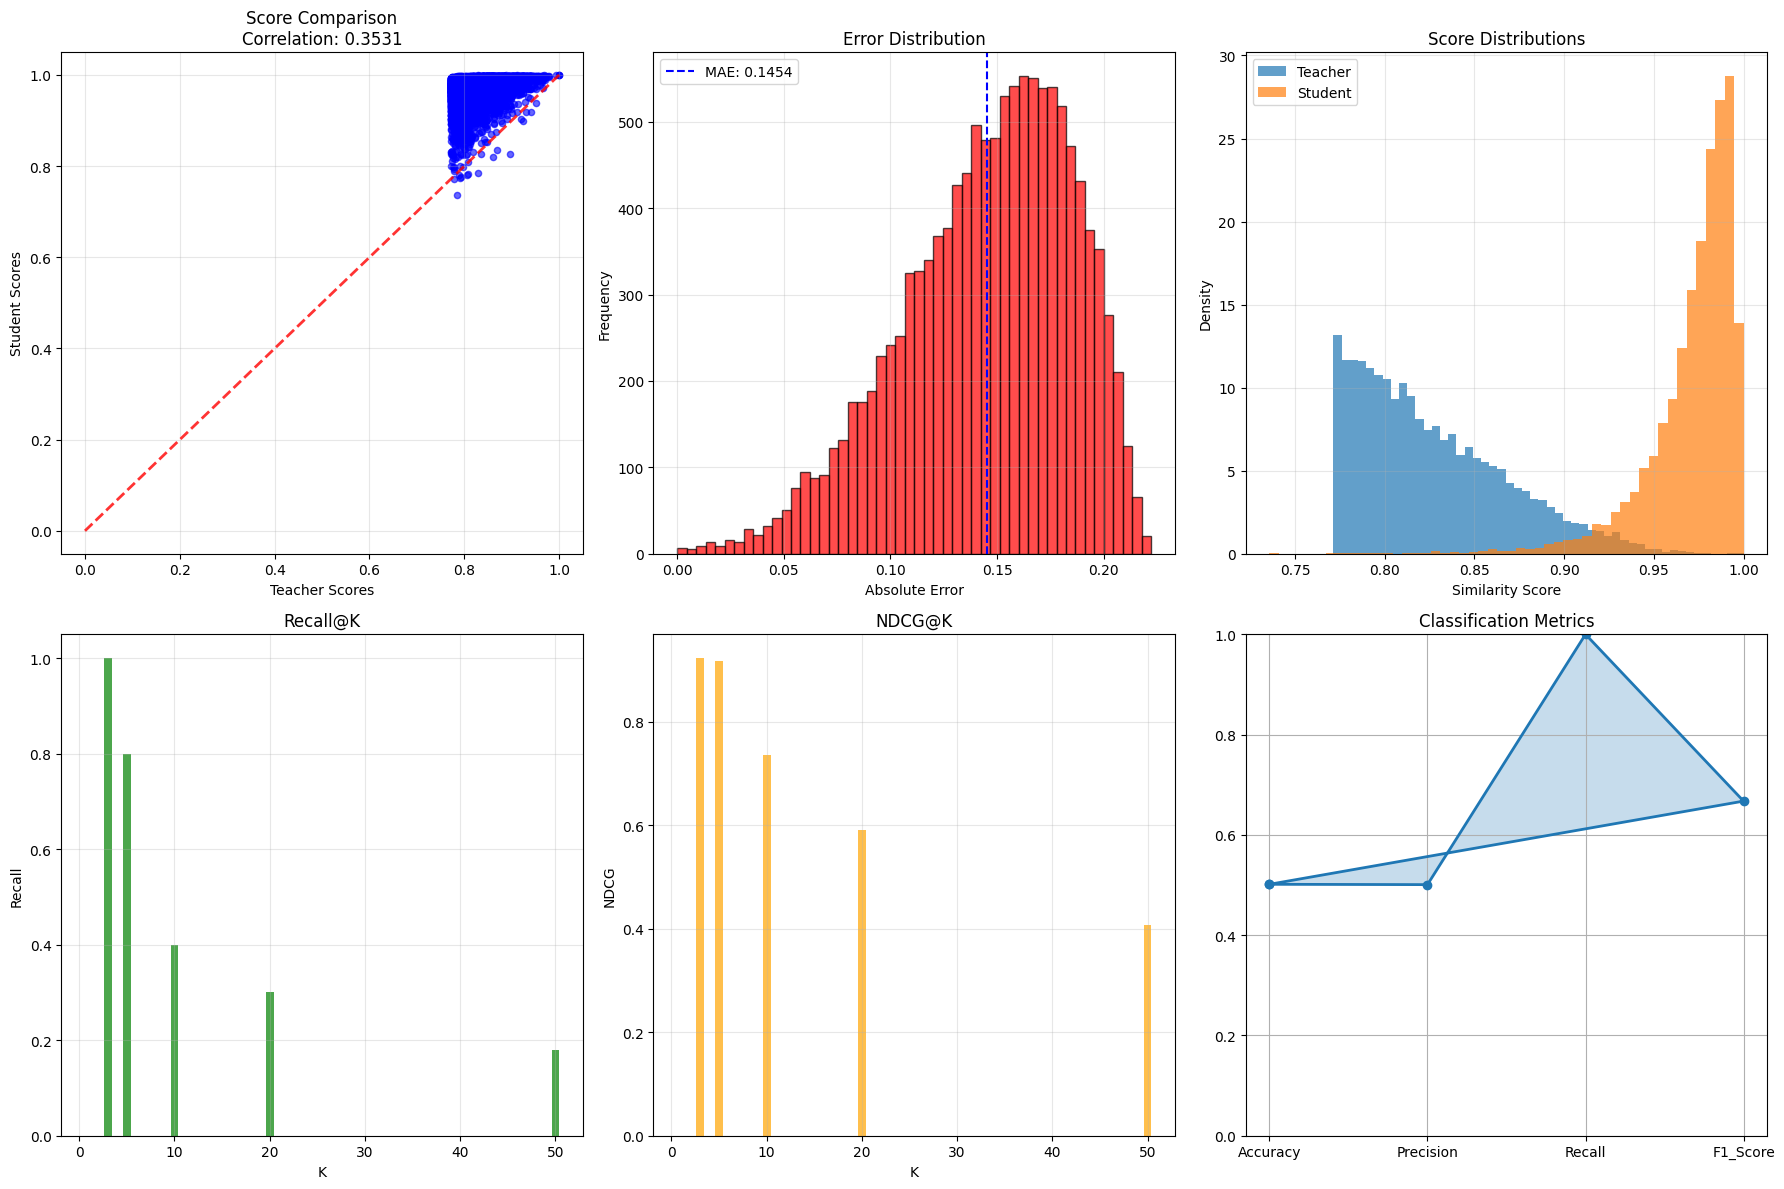


DETAILED ANALYSIS BY SCORE RANGES
High       [0.7-0.9): 11493 samples ( 93.7%) | MAE: 0.1507
Very High  [0.9-1.0):  773 samples (  6.3%) | MAE: 0.0677

PERFORMANCE SUMMARY
Key Performance Indicators:
  Pearson Correlation: 0.3531
  MAE: 0.1454
  Recall@10: 0.4000
  NDCG@10: 0.7347
  F1 Score: 0.6672

Overall Performance Rating: NEEDS IMPROVEMENT ❌
Primary Metric (Correlation): 0.3531


In [ ]:
# Run comprehensive evaluation
print("Running comprehensive evaluation...")

# Use ground truth teacher scores from your data
results = comprehensive_evaluation(
    teacher_scores=teacher_scores_ground_truth,
    student_scores=student_similarities
)

# Print results
print_results(results)

# Create visualizations
fig = plot_evaluation_results(
    teacher_scores_ground_truth,
    student_similarities,
    results
)

# Additional detailed analysis
print("\n" + "="*70)
print("DETAILED ANALYSIS BY SCORE RANGES")
print("="*70)

score_ranges = [
    (0.0, 0.3, "Very Low"),
    (0.3, 0.5, "Low"),
    (0.5, 0.7, "Medium"),
    (0.7, 0.9, "High"),
    (0.9, 1.0, "Very High")
]

for low, high, label in score_ranges:
    mask = (teacher_scores_ground_truth >= low) & (teacher_scores_ground_truth < high)
    if mask.sum() > 0:
        range_mae = np.mean(np.abs(teacher_scores_ground_truth[mask] - student_similarities[mask]))
        range_samples = mask.sum()
        range_percentage = (range_samples / len(teacher_scores_ground_truth)) * 100

        print(f"{label:10} [{low:.1f}-{high:.1f}): {range_samples:4d} samples ({range_percentage:5.1f}%) | MAE: {range_mae:.4f}")

# Performance summary
print("\n" + "="*70)
print("PERFORMANCE SUMMARY")
print("="*70)

# Key metrics for quick assessment
key_metrics = {
    'Pearson Correlation': results['regression']['Pearson_Correlation'],
    'MAE': results['regression']['MAE'],
    'Recall@10': results['ranking']['recall']['Recall@10'],
    'NDCG@10': results['ranking']['ndcg']['NDCG@10'],
    'F1 Score': results['classification']['F1_Score']
}

print("Key Performance Indicators:")
for metric, value in key_metrics.items():
    print(f"  {metric}: {value:.4f}")

# Performance rating
correlation = results['regression']['Pearson_Correlation']
if correlation > 0.8:
    rating = "EXCELLENT 🎉"
elif correlation > 0.7:
    rating = "VERY GOOD 👍"
elif correlation > 0.6:
    rating = "GOOD ✅"
elif correlation > 0.5:
    rating = "FAIR ⚠️"
else:
    rating = "NEEDS IMPROVEMENT ❌"

print(f"\nOverall Performance Rating: {rating}")
print(f"Primary Metric (Correlation): {correlation:.4f}")

In [ ]:
from scipy import stats
import pandas as pd

def statistical_analysis(teacher_scores, student_scores):
    """Perform statistical significance testing"""
    print("="*70)
    print("STATISTICAL SIGNIFICANCE ANALYSIS")
    print("="*70)

    # Paired t-test
    t_stat, p_value = stats.ttest_rel(teacher_scores, student_scores)
    print(f"Paired t-test: t = {t_stat:.4f}, p = {p_value:.4f}")

    if p_value < 0.05:
        print("✅ Statistically significant difference between teacher and student scores")
    else:
        print("❌ No statistically significant difference found")

    # Wilcoxon signed-rank test (non-parametric)
    w_stat, w_pvalue = stats.wilcoxon(teacher_scores, student_scores)
    print(f"Wilcoxon test: W = {w_stat:.4f}, p = {w_pvalue:.4f}")

    # Effect size
    cohens_d = np.mean(teacher_scores - student_scores) / np.std(teacher_scores - student_scores)
    print(f"Cohen's d (effect size): {cohens_d:.4f}")

    if abs(cohens_d) < 0.2:
        effect = "Very Small"
    elif abs(cohens_d) < 0.5:
        effect = "Small"
    elif abs(cohens_d) < 0.8:
        effect = "Medium"
    else:
        effect = "Large"

    print(f"Effect size interpretation: {effect}")

# Run statistical analysis
statistical_analysis(teacher_scores_ground_truth, student_similarities)

# Create results dataframe for detailed analysis
results_df = pd.DataFrame({
    'teacher_score': teacher_scores_ground_truth,
    'student_score': student_similarities,
    'absolute_error': np.abs(teacher_scores_ground_truth - student_similarities),
    'squared_error': (teacher_scores_ground_truth - student_similarities) ** 2
})

print("\n" + "="*70)
print("ERROR ANALYSIS SUMMARY")
print("="*70)

print(f"Worst predictions (top 5 highest errors):")
worst_predictions = results_df.nlargest(5, 'absolute_error')
for idx, row in worst_predictions.iterrows():
    print(f"  Teacher: {row['teacher_score']:.4f}, Student: {row['student_score']:.4f}, Error: {row['absolute_error']:.4f}")

print(f"\nBest predictions (top 5 lowest errors):")
best_predictions = results_df.nsmallest(5, 'absolute_error')
for idx, row in best_predictions.iterrows():
    print(f"  Teacher: {row['teacher_score']:.4f}, Student: {row['student_score']:.4f}, Error: {row['absolute_error']:.4f}")

# Save results to file
results_summary = {
    'timestamp': pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S"),
    'dataset_size': len(eval_data),
    'key_metrics': key_metrics,
    'detailed_results': results
}

import json
with open('/content/evaluation_results.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print(f"\n✅ Evaluation completed! Results saved to /content/evaluation_results.json")

STATISTICAL SIGNIFICANCE ANALYSIS
Paired t-test: t = -401.2895, p = 0.0000
✅ Statistically significant difference between teacher and student scores
Wilcoxon test: W = 1484.0000, p = 0.0000
Cohen's d (effect size): -3.6230
Effect size interpretation: Large

ERROR ANALYSIS SUMMARY
Worst predictions (top 5 highest errors):
  Teacher: 0.7717, Student: 0.9941, Error: 0.2224
  Teacher: 0.7742, Student: 0.9962, Error: 0.2220
  Teacher: 0.7724, Student: 0.9935, Error: 0.2211
  Teacher: 0.7726, Student: 0.9937, Error: 0.2210
  Teacher: 0.7729, Student: 0.9938, Error: 0.2209

Best predictions (top 5 lowest errors):
  Teacher: 1.0000, Student: 1.0000, Error: 0.0000
  Teacher: 1.0000, Student: 1.0000, Error: 0.0000
  Teacher: 1.0000, Student: 1.0000, Error: 0.0000
  Teacher: 0.7972, Student: 0.7982, Error: 0.0010
  Teacher: 0.8084, Student: 0.8100, Error: 0.0016

✅ Evaluation completed! Results saved to /content/evaluation_results.json
